In [ ]:
# load in file clients.csv
from google.colab import files
import pandas as pd

clients_csv = files.upload()

Saving client.csv to client.csv


In [ ]:
# create dataframe
df_clients = pd.read_csv(next(iter(clients_csv)))
df_clients.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [ ]:
import json

county_raw_json = """{
    "0": "HARJUMAA",
    "1": "HIIUMAA",
    "2": "IDA-VIRUMAA",
    "3": "JÄRVAMAA",
    "4": "JÕGEVAMAA",
    "5": "LÄÄNE-VIRUMAA",
    "6": "LÄÄNEMAA",
    "7": "PÄRNUMAA",
    "8": "PÕLVAMAA",
    "9": "RAPLAMAA",
    "10": "SAAREMAA",
    "11": "TARTUMAA",
    "12": "UNKNOWN",
    "13": "VALGAMAA",
    "14": "VILJANDIMAA",
    "15": "VÕRUMAA"
}"""

county_map = json.loads(county_raw_json)

df_clients['county_name'] = df_clients['county'].astype(str).map(county_map)

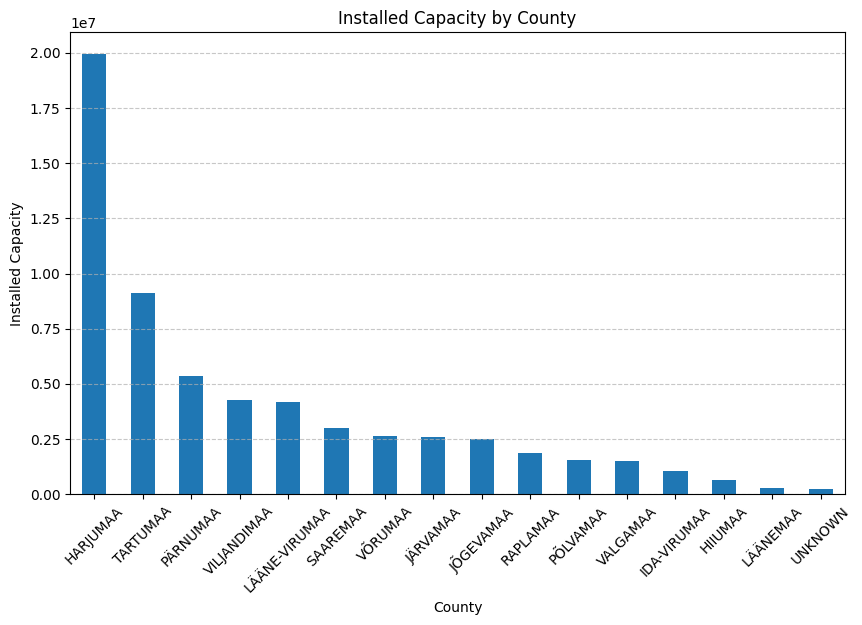

In [ ]:
import matplotlib.pyplot as plt

# Group and sum data by county
county_summary = df_clients.groupby('county_name')['installed_capacity'].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
county_summary.plot(kind='bar', rot=45)
plt.title('Installed Capacity by County')
plt.xlabel('County')
plt.ylabel('Installed Capacity')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# add electricity prices
prices_csv = files.upload()

Saving electricity_prices.csv to electricity_prices (1).csv


In [ ]:
#how installed solar capacity relates to electricity prices over time or by county.
df_prices = pd.read_csv(next(iter(prices_csv)))

# data_block to merge both dfs
df_merged = pd.merge(df_clients, df_prices, on="data_block_id", how="inner")

#df_merged["forecast_date"] = pd.to_datetime(df_merged["forecast_date"], errors="coerce")
#df_merged["date"] = pd.to_datetime(df_merged["date"], errors="coerce")

df_merged.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,county_name,forecast_date,euros_per_mwh,origin_date
0,1,0,108,952.89,0,2021-09-01,2,HARJUMAA,2021-09-02 00:00:00,96.99,2021-09-01 00:00:00
1,1,0,108,952.89,0,2021-09-01,2,HARJUMAA,2021-09-02 01:00:00,94.77,2021-09-01 01:00:00
2,1,0,108,952.89,0,2021-09-01,2,HARJUMAA,2021-09-02 02:00:00,93.88,2021-09-01 02:00:00
3,1,0,108,952.89,0,2021-09-01,2,HARJUMAA,2021-09-02 03:00:00,92.25,2021-09-01 03:00:00
4,1,0,108,952.89,0,2021-09-01,2,HARJUMAA,2021-09-02 04:00:00,91.83,2021-09-01 04:00:00


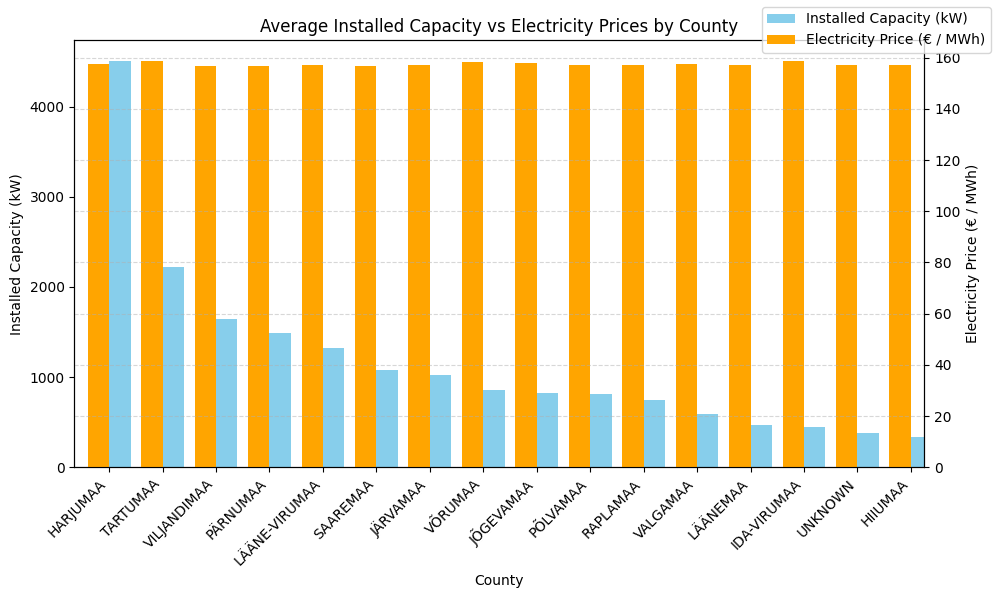

In [ ]:
# average price vs installed capacity per county
county_summary = (
    df_merged.groupby("county_name")[["installed_capacity", "euros_per_mwh"]]
    .mean()
    .sort_values("installed_capacity", ascending=False)
)

fig, ax1 = plt.subplots(figsize=(10, 6))

county_summary["installed_capacity"].plot(kind="bar", color="skyblue", ax=ax1, position=0, width=0.4, label="Installed Capacity (kW)")
ax1.set_ylabel("Installed Capacity (kW)")
ax1.set_xlabel("County")
ax1.set_xticklabels(county_summary.index, rotation=45, ha="right")

# y-axis for electricity prices
ax2 = ax1.twinx()
county_summary["euros_per_mwh"].plot(kind="bar", color="orange", ax=ax2, position=1, width=0.4, label="Electricity Price (€ / MWh)")
ax2.set_ylabel("Electricity Price (€ / MWh)")

plt.title("Average Installed Capacity vs Electricity Prices by County")
fig.legend(loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

#DATA_DIR = "/kaggle/input/predict-energy-behavior-of-prosumers/"
DATA_DIR = "./"

df_data = pd.read_csv(DATA_DIR + "train.csv")
df_client = pd.read_csv(DATA_DIR + "client.csv")
df_historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
df_forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
df_electricity_prices = pd.read_csv(DATA_DIR + "electricity_prices.csv")
df_gas_prices = pd.read_csv(DATA_DIR + "gas_prices.csv")
df_weather_station_to_county_mapping = pd.read_csv(DATA_DIR + "weather_station_to_county_mapping.csv")

In [3]:
def upsample_daily_to_hourly(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
    # unsample (process) client data. Client data is reported daily, but we need it hourly.
    # So we take ever row (1 day) and duplicate (explode) it into 24 rows
    df_hourly = df.copy(deep=True) # deep copy to not make changes to dataframe from parameter
    df_hourly[date_col] = pd.to_datetime(df_hourly[date_col])

    # create a column of lists, where each list contains [00:00, 01:00, ... 23:00] for that day
    df_hourly['datetime'] = df_hourly[date_col].apply(lambda x: [x + pd.Timedelta(hours=i) for i in range(24)])
    df_hourly = df_hourly.explode('datetime')

    # drop the original daily date column as it's no longer needed
    df_hourly = df_hourly.drop(columns=[date_col])
    return df_hourly


def process_forecast_weather(df_forecast: pd.DataFrame, location_map: dict) -> pd.DataFrame:
    """
    Cleans, aggregates, and pivots forecast weather data.

    Logic:
    1. Map Lat/Lon to County ID.
    2. Convert 'Origin Time' (when forecast was made) to 'Target Time' (when weather happens).
    3. Group forecasts into 'batches' (Day 1 forecast vs Day 2 forecast).
    4. Average the values per county/hour/batch.
    5. Pivot so batches become columns (e.g., temperature_1, temperature_2).
    """
    # Safety Copy
    df = df_forecast.copy(deep=True)

    # 1. Map Coordinates to County
    # We use the dictionary passed in from the main function
    df['county'] = [location_map.get((x, y), -1) for x, y in zip(df['latitude'], df['longitude'])]

    # Filter out valid locations only
    df = df[df['county'] != -1]

    # 2. Calculate Target Time
    # Standardize origin time to 02:00:00 (removes minute/second noise)
    df['origin_datetime'] = pd.to_datetime(df['origin_datetime'])
    df['origin_datetime'] = pd.to_datetime(df['origin_datetime'].dt.date.astype(str) + ' 02:00:00')

    # Target Time = Origin + Hours Ahead
    df['forecast_datetime'] = df['origin_datetime'] + pd.to_timedelta(df['hours_ahead'], unit='h')

    # We don't need origin time anymore
    df.drop(columns=['origin_datetime'], inplace=True)

    # 3. Create "Batches" (cumcount)
    # A batch represents how far out the forecast is (Day 1 vs Day 2)
    # (hours_ahead - 1) // 24 + 1 results in: 1 for 0-24h, 2 for 25-48h
    df['cumcount'] = (df['hours_ahead'] - 1) // 24 + 1

    # 4. Aggregate (Mean) by County, Time, and Batch
    # Identify feature columns (exclude IDs and Time)
    exclude_cols = ['latitude', 'longitude', 'hours_ahead', 'forecast_datetime', 'cumcount', 'county', 'data_block_id']
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    agg_dict = {col: 'mean' for col in feature_cols}
    # We must keep 'cumcount' in the groupby keys, so we don't aggregate it

    df_grouped = df.groupby(['county', 'forecast_datetime', 'cumcount']).agg(agg_dict)

    # 5. Pivot (Unstack)
    # Moves 'cumcount' from a row index to a column suffix
    df_pivoted = df_grouped.unstack(level=-1)

    # Flatten MultiIndex columns: ('temperature', 1) -> 'temperature_1'
    df_pivoted.columns = [f'{col[0]}_{col[1]}' for col in df_pivoted.columns]

    df_pivoted.reset_index(inplace=True)
    df_pivoted.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)

    # Handle missing values (if a forecast is missing, fill with 0 or strictly manage it)
    df_pivoted.fillna(0, inplace=True)

    return df_pivoted

def generate_features(
    df_data: pd.DataFrame,
    df_client: pd.DataFrame,
    df_gas_prices: pd.DataFrame,
    df_electricity_prices: pd.DataFrame,
    df_historical_weather: pd.DataFrame,
    df_forecast_weather: pd.DataFrame,
    df_weather_station_to_county_mapping: pd.DataFrame,
    train_start = '2021-09-01 11:00:00'
):
  # The weather data uses Latitude/Longitude, but the energy data uses "Counties".
  # We need a dictionary to translate coordinates into county IDs so we can join them later.
  # dictionary: {(lat, lon) -> county_id}
  df_weather_station_to_county_mapping = df_weather_station_to_county_mapping[
      df_weather_station_to_county_mapping.notnull().all(axis=1)
    ].sort_values(by="county")
  result_dict = dict(zip(
      zip(
        round(df_weather_station_to_county_mapping['latitude'],1),
        round(df_weather_station_to_county_mapping['longitude'],1)),
      df_weather_station_to_county_mapping['county']))
  df_historical_weather = df_historical_weather[df_historical_weather['datetime'] >= train_start]

  # ---------------------- client data -----------------------
  df_client_hourly = upsample_daily_to_hourly(df_client, date_col='date')
  if 'data_block_id' in df_client_hourly.columns:
    df_client_hourly.drop(columns=['data_block_id'], inplace=True)

  # merge into our main dataframe
  df_data['datetime'] = pd.to_datetime(df_data['datetime'])
  df_data = df_data.merge(df_client_hourly, on=['county','product_type','is_business','datetime'], how='left')
  # Filter data to ensure we don't go past the available client data
  client_end_date = df_client_hourly['datetime'].max()
  df_data = df_data[df_data['datetime'] <= client_end_date]

  # --------------- gas prices -------------------
  df_gas_hourly = upsample_daily_to_hourly(df_gas_prices, date_col='forecast_date')
  cols_to_drop = ['origin_date', 'data_block_id']
  df_gas_hourly.drop(columns=[c for c in cols_to_drop if c in df_gas_hourly.columns], inplace=True)

  gas_end_date = df_gas_hourly['datetime'].max()
  df_data = df_data[df_data['datetime'] <= gas_end_date]

  df_data = df_data.merge(df_gas_hourly, on=['datetime'], how='left')

  #--------------- electricity (already hourly) ------------------------------
  df_electricity_prices_try = df_electricity_prices.copy(deep=True)
  if 'origin_date' in df_electricity_prices_try.columns:
    df_electricity_prices_try.drop(columns=['origin_date'], inplace=True)
  if 'data_block_id' in df_electricity_prices_try.columns:
    df_electricity_prices_try.drop(columns=['data_block_id'], inplace=True)
  df_electricity_prices_try['forecast_date'] = pd.to_datetime(df_electricity_prices_try['forecast_date'])
  df_electricity_prices_try.rename(columns={"forecast_date": "datetime"}, inplace=True)
  df_data = df_data.merge(df_electricity_prices_try, on=['datetime'], how='left')

  # --- forecast weather ---
  df_forecast_processed = process_forecast_weather(df_forecast_weather, result_dict)
  df_data = df_data.merge(df_forecast_processed, on=['county', 'datetime'], how='left')

  # todo: process historical weather

  return df_data

In [5]:
combined_df = generate_features(
    df_data,
    df_client,
    df_gas_prices,
    df_electricity_prices,
    df_historical_weather,
    df_forecast_weather,
    df_weather_station_to_county_mapping)

In [6]:
combined_df.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id,eic_count,...,10_metre_v_wind_component_1,10_metre_v_wind_component_2,direct_solar_radiation_1,direct_solar_radiation_2,surface_solar_radiation_downwards_1,surface_solar_radiation_downwards_2,snowfall_1,snowfall_2,total_precipitation_1,total_precipitation_2
0,0,0,1,0.713,0,2021-09-01,0,0,0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,2021-09-01,0,1,0,108.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,2021-09-01,0,2,1,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,2021-09-01,0,3,1,17.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,2021-09-01,0,4,2,688.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
combined_df.columns

Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'eic_count', 'installed_capacity', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'euros_per_mwh', 'temperature_1',
       'temperature_2', 'dewpoint_1', 'dewpoint_2', 'cloudcover_high_1',
       'cloudcover_high_2', 'cloudcover_low_1', 'cloudcover_low_2',
       'cloudcover_mid_1', 'cloudcover_mid_2', 'cloudcover_total_1',
       'cloudcover_total_2', '10_metre_u_wind_component_1',
       '10_metre_u_wind_component_2', '10_metre_v_wind_component_1',
       '10_metre_v_wind_component_2', 'direct_solar_radiation_1',
       'direct_solar_radiation_2', 'surface_solar_radiation_downwards_1',
       'surface_solar_radiation_downwards_2', 'snowfall_1', 'snowfall_2',
       'total_precipitation_1', 'total_precipitation_2'],
      dtype='object')